In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

%matplotlib inline
mpl.rcParams['figure.figsize']=(16,10)
pd.set_option('display.max_rows',500)
import plotly.graph_objects as go

![CRISP_DM](../reports/figures/CRISP_DM.png)

In [71]:
df_analyse=pd.read_csv("../data/processed/COVID_small_sync_timeline_table.csv",sep=';',)
df_analyse.sort_values('date',ascending=True).head()

,doubling every day,doubling every two days,doubling every 4 days,doubling every 10 days,Italy,US,Spain,Germany,"Korea, South",India,date
0,100.0,100.000000,100.000000,100.000000,155.0,104.0,120.0,130.0,104.0,102.0,0.0
1,200.0,141.421356,118.920712,107.177346,229.0,174.0,165.0,159.0,204.0,113.0,1.0
2,400.0,200.000000,141.421356,114.869835,322.0,222.0,222.0,196.0,433.0,119.0,2.0
3,800.0,282.842712,168.179283,123.114441,453.0,337.0,259.0,262.0,602.0,142.0,3.0
4,1600.0,400.000000,200.000000,131.950791,655.0,451.0,400.0,482.0,833.0,156.0,4.0


# Helper Function

In [3]:
def quick_plot(x_in, df_input, y_scale='log',slider=False,mode_plot = 'markers+lines'):
    """ Quick basic plot for quick static evaluation of a time series
    
        you can push selective columns of your data frame by .iloc[:,[0,6,7,8]]
        
        Parameters:
        ----------
        x_in : array 
            array of date time object, or array of numbers
        df_input : pandas dataframe 
            the plotting matrix where each column is plotted
            the name of the column will be used for the legend
        scale: str
            y-axis scale as 'log' or 'linear'
        slider: bool
            True or False for x-axis slider
    
        
        Returns:
        ----------
        
    """
    fig = go.Figure()

    for each in df_input.columns:
        if 'doubling' in each:
            fig.add_trace(go.Scatter(
                        x=x_in,
                        y=df_input[each],
                        mode = 'markers',
                        line=dict(color='Grey', width=4, dash='dot'),
                        name=each,
                        opacity=0.10))
        
        else:
            fig.add_trace(go.Scatter(
                        x=x_in,
                        y=df_input[each],
                        mode = mode_plot,
                        name=each,
                        opacity=0.8))
    
        
        
        
    fig.update_layout(autosize=True,
        width=1024,
        height=768,
        font=dict(
            family="PT Sans, monospace",
            size=18,
            color="#7f7f7f"
            )
        )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle=-45,
                 nticks=20,
                 tickfont=dict(size=14,color="#7f7f7f")
                )
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()

In [93]:
quick_plot(df_analyse.date,
          df_analyse.iloc[:,3:-1],
          mode_plot='lines',slider=True)

# Fit Polynomial Curve

In [28]:
df_poly_check=df_analyse.iloc[0:120,4:-1].reset_index()
df_poly_check.tail()

,index,Italy,US,Spain,Germany,"Korea, South",India
115,115,237828.0,2510259.0,247486.0,192871.0,12121.0,742417.0
116,116,238159.0,2549864.0,247905.0,193371.0,12155.0,767296.0
117,117,238011.0,2590668.0,248469.0,194036.0,12198.0,793802.0
118,118,238275.0,2636414.0,248770.0,194458.0,12257.0,820916.0
119,119,238499.0,2687588.0,248970.0,194693.0,12306.0,849522.0


In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2,**kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))
#The polynomialFeatures generates different possibilities of polynomial of given degree, (for example if degree is 2 and 
# input variables are a and b the [1,a,,b,ab,a**2,b**2]). The polynomialFeatures is accompanied by a fit()command to convert 
# the independent ariables of the training data to equivalent polynomials. This polnomials are then passed to LinearRegression, 
# where the Linear rgression of the converted training set takes place. the LinearRegression function can be accompanied by a 
# predict function to predict teh output.

In [30]:
y=df_poly_check[['Germany','US','Italy','India']].unstack().sort_index(axis=0,level=1)
y.head()

Germany  0    130.0
US       0    104.0
Italy    0    155.0
India    0    102.0
Germany  1    159.0
dtype: float64

In [73]:
test_points=120
y_train=y[0:-test_points-1]
y_test=y[-test_points:]

In [74]:
X_train=np.arange(len(y_train)).reshape(-1,1)/4.0
X_test=np.arange(len(y_train),len(y_train)+test_points).reshape(-1,1)/4.0

In [75]:
import seaborn
seaborn.set(rc={'figure.figsize':(16,8)})

In [76]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

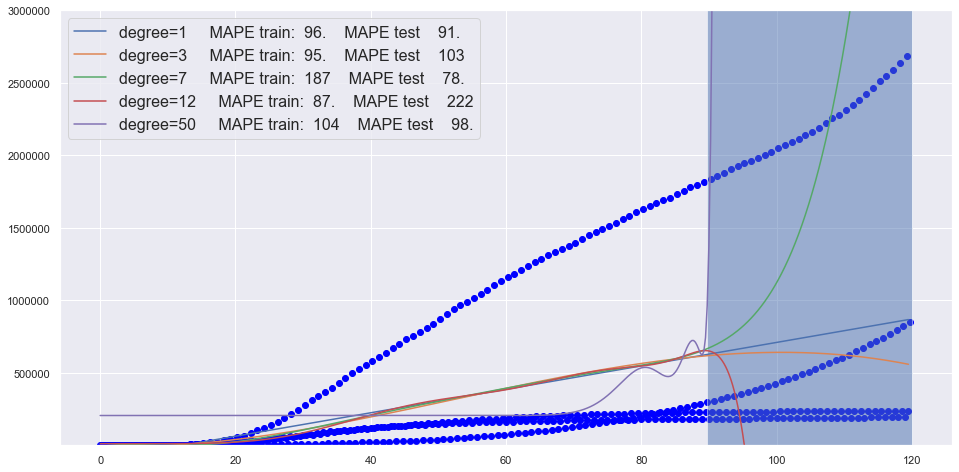

In [94]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(np.arange(len(y))/4,y, color='blue')
ax1.axvspan((len(y)-test_points-1)/4, len(y)/4, facecolor='b', alpha=0.5)

for degree in [1,3,7,12,50]:
    y_hat_insample=PolynomialRegression(degree).fit(X_train,y_train).predict(X_train)
    y_hat_test=PolynomialRegression(degree).fit(X_train,y_train).predict(X_test)

    X_plot=np.concatenate((X_train,X_test),axis=None)
    y_plot=np.concatenate((y_hat_insample,y_hat_test),axis=None)

    ax1.plot(X_plot, y_plot, label='degree={0}'.format(degree)+ 
                     '     MAPE train:  ' + str(mean_absolute_percentage_error(y_hat_insample, y_train))[0:3]
                     +'    MAPE test    ' +str(mean_absolute_percentage_error(y_hat_test, y_test))[0:3]) 

ax1.set_ylim(100,3000000)
ax1.set_yscale('linear')
ax1.legend(loc='best',
           prop={'size': 16});

# Regression Metrics

## Mean Absolut Error
## Mean Absolut Percentage Error (MAPE)
## Symmetric mean absolute percentage error